In [1]:
using Dierckx
#using CSV,DataFrames,LinearAlgebra
using DelimitedFiles
using Interpolations
using Dierckx
using PyCall
include("/Users/jlazar/research/TAMBO-MC/tambo/src/Units.jl")

(GeV = 1.0e9, TeV = 1.0e12, PeV = 1.0e15, eV = 1, m = 5.06773093741e6, km = 5.06773093741e9, cm = 50677.3093741, gr = 5.62e32, kg = 5.62e35, mwe = 2.1883118805254913e25, ρ_air0 = 5.289708721224576e15, ρ_rock0 = 1.1227136877701138e19)

In [2]:
function get_distance_coordinate(latitude, longitude, latmin, longmin)
    latmid = (latitude + latmin)/2.0
    m_per_deg_lon = (111132.954 - (559.822 * cos( 2.0 * latmid )) + (1.175 * cos( 4.0 * latmid)) + (0.0023 * cos( 6.0 * latmid)))
    m_per_deg_lat = (111412.82 * cos(latmid)) - (93.5*cos(latmid*3)) + (0.118*cos(5*latmid))
    delta_lat = latitude - latmin 
    delta_long = longitude - longmin 
    x = delta_long * (m_per_deg_lon * 180/pi)
    y = delta_lat * (m_per_deg_lat * 180/pi)
    x, y
end

get_distance_coordinate (generic function with 1 method)

In [3]:
data_input, header_input = readdlm("../resources/ColcaValleyData.txt",'\t', '\n', header=true)

(Any["T" -15.739750048 … 3905.0 "Colca_Valley_Longs_and_Lats"; "T" -15.736415521 … 3779.1 ""; … ; "T" -15.409631924 … 4958.5 ""; "T" -15.409631924 … 5024.4 ""], AbstractString["type" "latitude" … "altitude (m)" "name"])

In [4]:
latitude = deg2rad.(data_input[:,2])
longitude = deg2rad.(data_input[:,3])
elevation = (data_input[:,4])
lat_min = minimum(latitude)
lat_max = maximum(latitude)
long_min = minimum(longitude)
long_max = maximum(longitude)

-1.2555305715942784

In [5]:
a = get_distance_coordinate.(latitude, longitude, Ref(lat_min), Ref(long_min));

In [6]:
out = zeros(3, length(a))
for i in 1:length(a)
    out[1:2, i] .= a[i]
    out[3, i] = elevation[i]
end
out

3×9802 Matrix{Float64}:
    0.0   446.686   893.372  1340.06  …  42881.2  43327.9  43774.6  44221.3
    0.0   357.37    357.37    357.37     35407.7  35407.7  35407.7  35407.7
 3905.0  3779.1    3816.0    3856.3       4909.1   4984.2   4958.5   5024.4

In [7]:
open("new_file.txt", "w") do io
    writedlm(io, transpose(out), '\t')
end

In [8]:
itp = interpolate(out, BSpline(Quadratic(Reflect(OnCell()))))

3×9802 interpolate(OffsetArray(::Matrix{Float64}, 0:4, 0:9803), BSpline(Quadratic(Reflect(OnCell())))) with element type Float64:
    1.42109e-14   446.686   893.372  …  42881.2  43327.9  43774.6  44221.3
    0.0           357.37    357.37      35407.7  35407.7  35407.7  35407.7
 3905.0          3779.1    3816.0        4909.1   4984.2   4958.5   5024.4

In [9]:
function load_python_spline(p)
    np = PyNULL()
    copy!(np, pyimport("numpy"))
    x = np.load(p, allow_pickle=true)
    spl = x[1]
end

load_python_spline (generic function with 1 method)

In [10]:
spl = load_python_spline("../resources/tambo_spline.npy")

PyObject <scipy.interpolate.fitpack2.SmoothBivariateSpline object at 0x7fcaa85c9850>

In [11]:
Y = zeros(100)
for (i, y) in enumerate(Set(out[2,:]))
    Y[i] = y
end

In [12]:
X = LinRange(0, maximum(out[1,:]), 101)
Y = sort(Y)
Z = zeros((101, 100))
for (j, x) in enumerate(X) for (i, y) in enumerate(Y)
        Z[j, i] = spl(x,y)[1]
end
end

In [13]:
new_spl = Spline2D(X, Y, Z, kx=3, ky=3, s=0.1)
function eval_spl(x, y)
    evaluate(new_spl, x, y)
end

eval_spl (generic function with 1 method)

In [14]:
using Plots

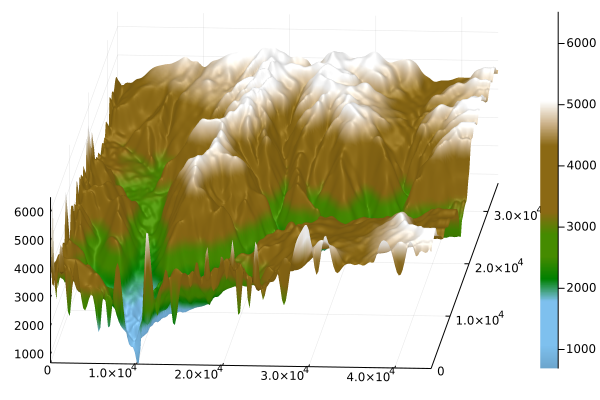

In [15]:
sfc = surface(
    LinRange(0, X[end], 200),
    LinRange(0, Y[end], 200),
    eval_spl,
    c=cgrad(palette([
        :skyblue3,
        :skyblue2,
        :skyblue2,
        :skyblue2,
        :green, 
        :chartreuse4,
        :chartreuse4,
        :goldenrod4,
        :goldenrod4,
        :goldenrod4,
        :goldenrod4,
        :navajowhite3,
        :white,
        :white,
        :white,
        :white,
        :white,
    ])),   
)
plot!(sfc, camera=(10, 60))

In [16]:
using Pkg
Pkg.add("JLD2")
using JLD2

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [17]:
jldsave("/Users/jlazar/research/TAMBO-MC/resources/tambo_spline.jld2"; spline=new_spl)

In [18]:
f = jldopen("/Users/jlazar/research/TAMBO-MC/resources/tambo_spline.jld2", "r")

JLDFile /Users/jlazar/research/TAMBO-MC/resources/tambo_spline.jld2 (read-only)
 └─🔢 spline

In [19]:
evaluate(f["spline"], 1000, 1000)

4050.4532653703823

In [20]:
close(f)

In [25]:
methods(split)

# 4 methods for generic function "split":
[1] split(str::AbstractString; limit, keepempty) in Base at strings/util.jl:459
[2] split(str::T, splitter::Union{Tuple{Vararg{AbstractChar}}, Set{<:AbstractChar}, AbstractVector{<:AbstractChar}}; limit, keepempty) where T<:AbstractString in Base at strings/util.jl:421
[3] split(str::T, splitter::AbstractChar; limit, keepempty) where T<:AbstractString in Base at strings/util.jl:425
[4] split(str::T, splitter; limit, keepempty) where T<:AbstractString in Base at strings/util.jl:417

In [64]:
io = open("/Users/jlazar/Downloads/dsigmady_csms_nuebar_proton.dat", "r")
nenergy = 0
npts = 0
out = zeros((2, 8, 551))
i = 0
# j = 0 
while !eof(io)
    l = readline(io)
    sl = split(l, " "; keepempty=false)
    if length(sl)==1
        i += 1
        j = 0
        e = parse(Float64, sl[1])
    elseif length(sl)==2
        j += 1
        y = parse(Float64, sl[1])
        xs = parse(Float64, sl[2])
        out[1, i, j] = y
        out[2, i, j] = xs
    end
end
println(npts)
println(nenergy)
close(io)

0
0


In [68]:
out[1, 1, :]

551-element Vector{Float64}:
 0.99
 0.988200000018
 0.9863999999370001
 0.9846000000540001
 0.982799999973
 0.9810000000900001
 0.97919999991
 0.97739999973
 0.97559999955
 0.97380000036
 0.97200000018
 0.9702
 0.9684000008100001
 ⋮
 0.01980000000000002
 0.017999982000000025
 0.016199964000000032
 0.01439998560000002
 0.012599987400000017
 0.010800009000000005
 0.008999991000000013
 0.00719997300000002
 0.005399994600000007
 0.003599996400000005
 0.0018000179999999922
 0.0001